# YouDo 2 - Recommendation for MovieLens Data

In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd

### Functions to be used

In [2]:
# returns the similarity matrix

def fit(r: np.ndarray, beta: int = 1):
    m, n = r.shape
    mu = np.nanmean(r, axis=1)
    sim = np.zeros((m, m))
    
    idf = np.log(1 + n / (~np.isnan(r)).sum(axis=0)) # kolonun eleman sayisi/dolu eleman sayisi
    #print(idf)

    for i in trange(m):
        for j in range(m):
            mask = ~np.isnan(r[i, :]) & ~np.isnan(r[j, :]) # 2 userda ortak dolu indexleri filtreler           

            si = r[i, mask] - mu[i]   # i'nin j ile ortak dolu rateleri - i'nin verdiği ort. puan
            sj = r[j, mask] - mu[j]   # j'nin i ile ortak dolu rateleri - j'nin verdiği ort. puan

            sim[i][j] = (si * sj * idf[mask]).sum() / (
                np.sqrt((idf[mask] * (si ** 2)).sum()) * np.sqrt((idf[mask] * (sj ** 2)).sum()) )
               
            total_intersection = mask.sum()  # ortak ratelenmis urun sayisi

            sim[i][j] *= min(total_intersection, beta) / beta
    sim[np.isnan(sim)] = 0  # nan gelenleri 0 yap
    return sim

In [3]:
def predict(r: np.array,sim, u: int, top_k: int = 3) -> np.ndarray:
     
    mu = np.nanmean(r, axis=1)
    _, n = r.shape
    score = np.zeros(n)
    
    for j in trange(n):
         
        users_rated_j = np.nonzero(~np.isnan(r[:, j]))[0]  # j'de nan olmayanlarin indexleri
        topk_users = users_rated_j[sim[u, users_rated_j].argsort()[::-1]][:top_k]

        mean_centered_topk_user_rate = r[topk_users, j] - mu[topk_users]

        w = sim[u, topk_users] 
        w[np.isnan(w)] = 0

        pred = (np.dot(mean_centered_topk_user_rate, w) / np.abs(w).sum()) + mu[u]
        score[j] = pred
        
    return score

In [4]:
def reco(r: np.ndarray, Type: str) -> np.ndarray:
    r_pred = []

    if Type=='item':
        r = r.T
        
    sim = fit(r,beta=3)
    
    for u in range(r.shape[0]):
        u0 = predict(r,sim, u, top_k=5)
        r_pred.append(u0)

    return np.array(r_pred)

In [5]:
def cal_loss(beta,X,y):
    
    m = len(y)  
    y_pred = np.dot(X, beta)
    loss = (1/2*m) * np.sum(np.square(y_pred-y))
    
    return loss


def gradient_descent(X,y,learning_rate=0.01,iterations=100):
    
    beta = np.random.randn(X.shape[1],1)
    m = len(y)
    loss_history = np.zeros(iterations)

    for it in range(iterations):    
        y_pred = np.dot(X,beta)
        err = y_pred - y
        beta = beta -(1/m)*learning_rate*(np.dot(X.T,err))
        loss_history[it]  = cal_loss(beta,X,y)
        
    return beta, loss_history


def stocashtic_gradient_descent(X,y,learning_rate=0.01,iterations=10):

    m = len(y)
    loss_history = np.zeros(iterations)
    beta = np.random.randn(X.shape[1],1)
    
    for it in range(iterations):
        loss = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            y_pred = np.dot(X_i,beta)

            beta = beta -(1/m)*learning_rate*( X_i.T.dot((y_pred - y_i)))
            loss += cal_loss(beta,X_i,y_i)
        loss_history[it]  = loss
        
    return beta, loss_history

In [6]:
def prep_test_set(R, leng, test):
    
    irow, jcol = np.where(~np.isnan(R))

    idx = np.random.choice(np.arange(leng), test, replace=False)
    test_irow = irow[idx]
    test_jcol = jcol[idx]

    R_copy = R.copy()

    for i, j in zip(test_irow, test_jcol):
        R_copy[i][j] = np.nan
               
    return R_copy, test_irow, test_jcol

## Dataset

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.data', delimiter=r'\t',
                 #names=['user_id', 'item_id', 'rating', 'timestamp'])

r = df.pivot(index='user_id', columns='item_id', values='rating').values

r = r[~np.isnan(r).all(axis=1)]
r = r[:,~np.isnan(r).all(axis=0)]
r

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

<br>

## User based and item based predictions

In [8]:
X_test, irow_xtest, jcol_xtest = prep_test_set(r, 100_000,  10_000)
X_test

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [9]:
r_pred_user = reco(X_test, 'user')
r_pred_item = reco(X_test, 'item')

C:\Users\EYLUL~1.ERL\AppData\Local\Temp/ipykernel_5836/1415009958.py:8: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(1 + n / (~np.isnan(r)).sum(axis=0)) # kolonun eleman sayisi/dolu eleman sayisi
  0%|                                                                                          | 0/943 [00:00<?, ?it/s]C:\Users\EYLUL~1.ERL\AppData\Local\Temp/ipykernel_5836/1415009958.py:18: RuntimeWarning: invalid value encountered in double_scalars
  sim[i][j] = (si * sj * idf[mask]).sum() / (
  0%|                                                                                         | 0/1682 [00:00<?, ?it/s]C:\Users\EYLUL~1.ERL\AppData\Local\Temp/ipykernel_5836/1172998327.py:17: RuntimeWarning: invalid value encountered in double_scalars
  pred = (np.dot(mean_centered_topk_user_rate, w) / np.abs(w).sum()) + mu[u]
100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 43289.07it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 43187.31it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 39700.28it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 32355.03it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 34645.45it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 33774.83it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 39249.70it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 43262.79it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 33750.76it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 36537.38it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 36744.04it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 43233.09it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 33948.90it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 36462.97it/s]
C:\Users\EYLUL~1.ERL\AppData\Local\Temp/ipykernel_5836/1415009958.py:5: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(r, axis=1)


100%|██████████████████████████████████████████████████████████████████████████████| 1682/1682 [01:56<00:00, 14.40it/s]
C:\Users\EYLUL~1.ERL\AppData\Local\Temp/ipykernel_5836/1172998327.py:3: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(r, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43003.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43008.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 23618.66it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 44583.04it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 47327.20it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 45053.29it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 36296.16it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 42985.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 32361.02it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43004.24it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 24551.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 33124.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 37379.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43009.85it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 45054.32it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 44891.20it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 41266.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43006.57it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 34938.95it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 42873.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 25544.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 43008.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 33484.55it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 32400.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 44410.33it/s]


In [10]:
r_pred_user

array([[4.37653051, 2.85414178, 3.74574276, ..., 2.47287254, 3.59934274,
        3.21475864],
       [4.22668401, 3.38620512, 3.71777215, ..., 2.64031621, 3.76678641,
        3.3822023 ],
       [3.12954064, 3.01976281, 2.55630888, ..., 3.91674376, 2.79027356,
        2.48471681],
       ...,
       [4.81711822, 4.01711337, 3.04062455, ...,        nan, 4.03951368,
        3.65492958],
       [4.80357397, 4.09628036, 3.5609464 , ..., 3.19245524, 4.31892544,
        3.93434134],
       [4.12723114, 4.28615245, 2.94912073, ...,        nan, 3.4501097 ,
        3.0655256 ]])

In [11]:
r_pred_item

array([[4.52012892, 4.08852019, 2.62717489, ..., 4.71139238, 4.48196512,
        4.75482616],
       [2.7727464 , 3.30758768, 3.11587577, ..., 3.78950196, 4.11615427,
        4.36777457],
       [4.23943625, 3.38278987, 2.38656899, ..., 3.07983471, 3.91592453,
        2.20639807],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [12]:
dic_outputs = {}

In [13]:
err_user = []
err_item = []
for u, j in zip(irow_xtest,jcol_xtest):
    y_pred_user = r_pred_user[u, j]
    y_pred_item = r_pred_item[j, u]
    y = r[u, j]
    err_user.append((y_pred_user - y) ** 2)
    err_item.append((y_pred_item - y) ** 2)
print(f"RMSE for user based preds: {np.sqrt(np.nanmean(np.array(err_user)))}")
print(f"RMSE for item based preds: {np.sqrt(np.nanmean(np.array(err_item)))}")

RMSE for user based preds: 1.008387328228529
RMSE for item based preds: 1.02224517580656


In [14]:
dic_outputs['user_based'] = np.sqrt(np.nanmean(np.array(err_user)))
dic_outputs['item_based'] = np.sqrt(np.nanmean(np.array(err_item)))

<br>

## Gradient Descent

In [15]:
x1 = []
x2 = []
y = []
r_pred_item_T = r_pred_item.T

for i in range(r_pred_user.shape[0]-1):
    for j in range(r_pred_user.shape[1]-1):
        x1.append(r_pred_user[i][j])
        x2.append(r_pred_item_T[i][j])
        y.append(r[i][j])

In [16]:
df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))
df

,x1,x2,y
0,4.376531,4.520129,5.0
1,2.854142,2.772746,3.0
2,3.745743,4.239436,4.0
3,3.838604,2.573646,3.0
4,2.965700,2.262554,3.0
...,...,...,...
1583497,4.046738,NaN,NaN
1583498,2.192455,NaN,NaN
1583499,4.192455,NaN,NaN
1583500,3.192455,NaN,NaN


In [17]:
df_reg = df.dropna()
df_reg

,x1,x2,y
0,4.376531,4.520129,5.0
1,2.854142,2.772746,3.0
2,3.745743,4.239436,4.0
3,3.838604,2.573646,3.0
4,2.965700,2.262554,3.0
...,...,...,...
1582789,4.818205,4.006421,4.0
1582848,4.527264,3.652716,4.0
1582870,4.750824,4.954739,5.0
1583024,4.589830,4.354253,4.0


* Prepared the predictions as an input for gradent descent. 75% of predictions will be used for training.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_reg[['x1','x2']].values, df_reg[['y']].values,test_size=0.25, random_state=42)

Beta0:          1.774,
Beta1:          -0.761
Final loss/MSE:  1662853600.632


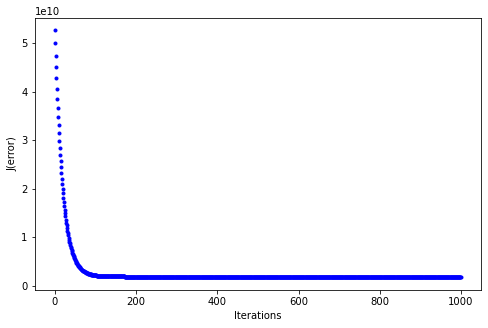

In [20]:
lr =0.001
n_iter = 1000

beta,loss_history = gradient_descent(X_train,y_train,lr,n_iter)
beta_gd = beta
print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('J(error)')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),loss_history,'b.')

* After around 150-200 iterations the loss is like flat so the remaining iterations are not needed.
* Learning rate will be used as 200.

* **The mean squared error was around 1 in the user based and item based predictions, gradient descent decreased the error nearly 50%.**

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
pred_vals = X_test[:,0] * beta[0][0] + X_test[:,1] * beta[1][0]
mean_squared_error(pred_vals,y_test)

0.5869763003887353

In [23]:
dic_outputs['grad'] = mean_squared_error(pred_vals,y_test)

### Learning rate optimization for GD

In [24]:
lr_range = np.arange(0.00001, 0.1, 0.001)
n_iter = 200
loss_list = []

for lr in lr_range:

    beta,loss_history = gradient_descent(X_train,y_train,lr,n_iter)
    loss_list.append(loss_history[-1]) 

In [25]:
df_lr = pd.DataFrame(dict(lr=lr_range, loss=loss_list))
optimized_lr = df_lr[df_lr.loss == min(df_lr.loss)].lr.values[0]
optimized_lr

0.04301000000000001

Beta0:          0.645,
Beta1:          0.360
Final loss/MSE:  655094173.727


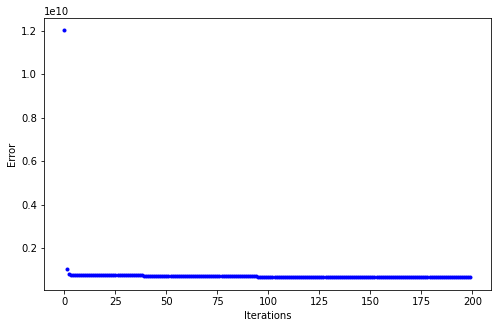

In [26]:
lr = optimized_lr
n_iter = 200

beta,loss_history = gradient_descent(X_train,y_train,lr,n_iter)

print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('Error')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),loss_history,'b.')

<br>

* **Rmse before learning rate optimization was around 0.5 ; optimizing learning rate decreased the error.**

In [27]:
pred_vals = X_test[:,0] * beta[0][0] + X_test[:,1] * beta[1][0]
mean_squared_error(pred_vals,y_test)

0.23052798881290534

In [28]:
dic_outputs['optimized_grad'] = mean_squared_error(pred_vals,y_test)

<br>

## Stochastic Gradient Descent

In [29]:
def stocashtic_gradient_descent(X,y,learning_rate=0.01,iterations=10):

    m = len(y)
    loss_history = np.zeros(iterations)
    beta = np.random.randn(X.shape[1],1)
    
    for it in range(iterations):
        loss = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            y_pred = np.dot(X_i,beta)

            beta = beta -(1/m)*learning_rate*( X_i.T.dot((y_pred - y_i)))
            loss += cal_loss(beta,X_i,y_i)
        loss_history[it]  = loss
        
    return beta, loss_history

In [30]:
lr =0.01
n_iter = 100

beta,loss_history = stocashtic_gradient_descent(X_train,y_train,lr,n_iter)
beta_sgd = beta

print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

Beta0:          0.540,
Beta1:          0.464
Final loss/MSE:  8401.481


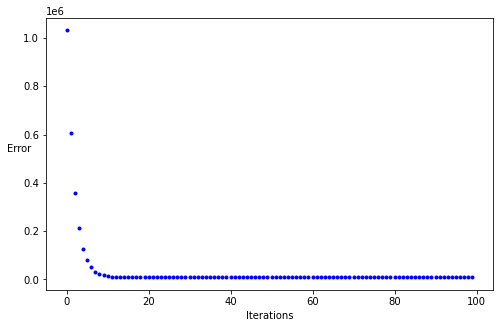

In [31]:
fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('Error',rotation=0)
ax.set_xlabel('Iterations')

_=ax.plot(range(n_iter),loss_history,'b.')

In [32]:
pred_vals = X_test[:,0] * beta_sgd[0][0] + X_test[:,1] * beta_sgd[1][0]
mean_squared_error(pred_vals,y_test)

0.2232429743325131

In [33]:
dic_outputs['sgd'] = mean_squared_error(pred_vals,y_test)

### Optimizing learning rate for SGD

In [34]:
lr_range = np.arange(0.001, 1, 0.1)

In [35]:
n_iter = 40
loss_list = []
for lr in lr_range:

    beta,loss_history = stocashtic_gradient_descent(X_train,y_train,lr,n_iter)
    loss_list.append(loss_history[-1])

In [36]:
df_lr = pd.DataFrame(dict(lr=lr_range, loss=loss_list))
optimized_lr = df_lr[df_lr.loss == min(df_lr.loss)].lr.values[0]
optimized_lr

0.801

Beta0:          0.407,
Beta1:          0.595
Final loss/MSE:  8397.015


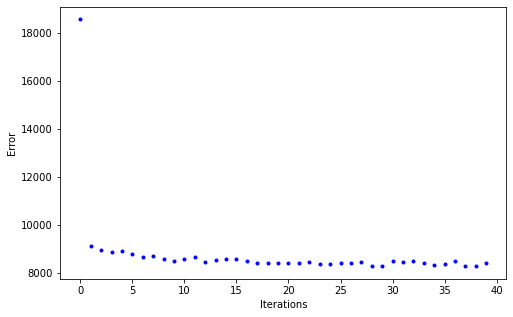

In [37]:
lr = optimized_lr
n_iter = 40

beta,loss_history = stocashtic_gradient_descent(X_train,y_train,lr,n_iter)

print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('Error')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),loss_history,'b.')

In [38]:
pred_vals = X_test[:,0] * beta[0][0] + X_test[:,1] * beta[1][0]
mean_squared_error(pred_vals,y_test)

0.22044836268877882

In [39]:
dic_outputs['optimized_sgd'] = mean_squared_error(pred_vals,y_test)

<br>

## Part II -  loss function upgraded

In [40]:
def cal_loss2(beta,X,y, lam):
    
    m = len(y)
    
    y_pred = np.dot(X, beta)
    loss = (1/2*m) * np.sum(np.square(y_pred-y)) + (lam/2)*((np.square(X_train)[:,0]).sum() + np.square(X_train)[:,1].sum())
    return loss

In [41]:
def gradient_descent(X,y,learning_rate=0.01,iterations=100, lam=0.01):
    
    beta = np.random.randn(X.shape[1],1)
    m = len(y)
    loss_history = np.zeros(iterations)
    beta_history = np.zeros((iterations,2))
    for it in range(iterations):
        
        y_pred = np.dot(X,beta)
        err = y_pred - y
        beta = beta -(1/m)*learning_rate*(np.dot(X.T,err))
        beta_history[it,:] = beta.T
        loss_history[it]  = cal_loss2(beta,X,y,lam)
        
    return beta, loss_history, beta_history

Beta0:          0.662,
Beta1:          0.343
Final loss/MSE:  659580541.770


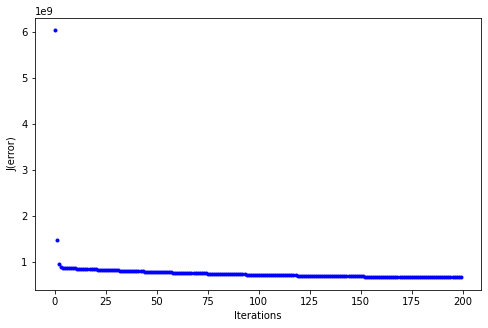

In [42]:
lr = 0.05
n_iter = 200

beta,loss_history,beta_history = gradient_descent(X_train,y_train,lr,n_iter, lam=0.01)

print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('J(error)')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),loss_history,'b.')

In [43]:
pred_vals = X_test[:,0] * beta[0][0] + X_test[:,1] * beta[1][0]
mean_squared_error(pred_vals,y_test)

0.2321083957353019

In [44]:
dic_outputs['part2'] = mean_squared_error(pred_vals,y_test)

### Optimizing lambda for GD with new loss function

In [45]:
lam_range = np.arange(0.0001, 0.1, 0.001)

n_iter = 200
loss_list = []
for lam in lam_range:

    beta,loss_history,beta_history = gradient_descent(X_train,y_train,lr,n_iter, lam)
    loss_list.append(loss_history[-1]) 

In [46]:
df_lam = pd.DataFrame(dict(lam=lam_range, loss=loss_list))
optimized_lam = df_lam[df_lam.loss == min(df_lam.loss)].lam.values[0]
optimized_lam

0.0191

Beta0:          0.567,
Beta1:          0.437
Final loss/MSE:  638625580.633


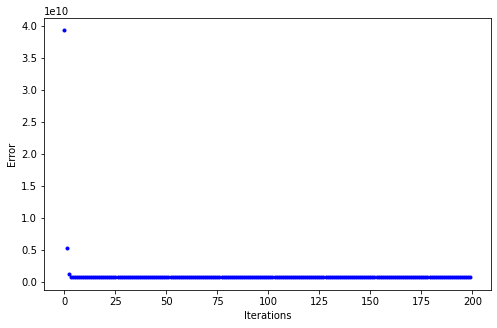

In [47]:
lam = optimized_lam
n_iter = 200

beta,loss_history,beta_history = gradient_descent(X_train,y_train,lr,n_iter, lam)

print('Beta0:          {:0.3f},\nBeta1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
print('Final loss/MSE:  {:0.3f}'.format(loss_history[-1]))

fig,ax = plt.subplots(figsize=(8,5))

ax.set_ylabel('Error')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),loss_history,'b.')

In [48]:
pred_vals = X_test[:,0] * beta[0][0] + X_test[:,1] * beta[1][0]
mean_squared_error(pred_vals,y_test)

0.22471067042267337

In [49]:
dic_outputs['part2_optimized'] = mean_squared_error(pred_vals,y_test)

<br>

## Conclusion

In the table below, the derived root mean squared errors of each method can be observed.

* Combined output of the user based and item based recommendations, result much better than the two methods seperately.
* Gradient results are somewhat satisfying, we can see that optimizing the parameters significantly incerase accuracy in each method.
* Stochastic Gradient Descent tends to have more accurate results in general. Due to randomness, it may result even better with more detailed optimization which could not be accomplished because of time limitations.
* Part 2 is where we pass the upgraded loss function into gradient descent. It results better than standard gradient descent.

In [50]:
pd.DataFrame(dic_outputs.items(), columns=['method', 'rmse'])

,method,rmse
0,user_based,1.008387
1,item_based,1.022245
2,grad,0.586976
3,optimized_grad,0.230528
4,sgd,0.223243
5,optimized_sgd,0.220448
6,part2,0.232108
7,part2_optimized,0.224711
